In [1]:
""" Simple implementation of Generative Adversarial Neural Network """
import os
import numpy as np

from IPython.core.debugger import Tracer

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam

import matplotlib.pyplot as plt
plt.switch_backend('agg')   # allows code to run without a system DISPLAY

Using TensorFlow backend.


In [19]:
class GAN(object):
    """ Generative Adversarial Network class """
    def __init__(self, width=28, height=28, channels=1):

        self.width = width
        self.height = height
        self.channels = channels

        self.shape = (self.width, self.height, self.channels)

        self.optimizer = Adam(lr=0.0002, beta_1=0.5, decay=8e-8)

        self.G = self.__generator()
        self.G.compile(loss='binary_crossentropy', optimizer=self.optimizer)

        self.D = self.__discriminator()
        self.D.compile(loss='binary_crossentropy', optimizer=self.optimizer, metrics=['accuracy'])

        self.stacked_generator_discriminator = self.__stacked_generator_discriminator()

        self.stacked_generator_discriminator.compile(loss='binary_crossentropy', optimizer=self.optimizer)


    def __generator(self):
        """ Declare generator """

        model = Sequential()
        model.add(Dense(256, input_shape=(100,)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(self.width  * self.height * self.channels, activation='tanh'))
        model.add(Reshape((self.width, self.height, self.channels)))

        return model

    def __discriminator(self):
        """ Declare discriminator """

        model = Sequential()
        model.add(Flatten(input_shape=self.shape))
        model.add(Dense((self.width * self.height * self.channels), input_shape=self.shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(np.int64((self.width * self.height * self.channels)/2)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        return model

    def __stacked_generator_discriminator(self):

        self.D.trainable = False

        model = Sequential()
        model.add(self.G)
        model.add(self.D)

        return model

    def train(self, X_train, epochs=20000, batch = 32, save_interval = 100):
        
        list_d_loss = []
        list_g_loss = []
        for cnt in range(epochs):

            ## train discriminator
            random_index = np.random.randint(0, len(X_train) - np.int64(batch/2))
            legit_images = X_train[random_index : random_index + np.int64(batch/2)].reshape(np.int64(batch/2), self.width, self.height, self.channels)

            gen_noise = np.random.normal(0, 1, (np.int64(batch/2), 100))
            syntetic_images = self.G.predict(gen_noise)

            x_combined_batch = np.concatenate((legit_images, syntetic_images))
            y_combined_batch = np.concatenate((np.ones((np.int64(batch/2), 1)), np.zeros((np.int64(batch/2), 1))))

            d_loss = self.D.train_on_batch(x_combined_batch, y_combined_batch)
            
            # train generator

            noise = np.random.normal(0, 1, (batch, 100))
            y_mislabled = np.ones((batch, 1))

            g_loss = self.stacked_generator_discriminator.train_on_batch(noise, y_mislabled)
            
            list_d_loss.append(d_loss)
            list_g_loss.append(g_loss)
            print ('epoch: %d, [Discriminator :: d_loss: %f], [ Generator :: loss: %f]' % (cnt, d_loss[0], g_loss))

            if cnt % save_interval == 0:
                self.plot_images(save2file=True, step=cnt)
        
        self.list_d_loss = list_d_loss
        self.list_g_loss = list_g_loss

    def plot_images(self, save2file=False, samples=16, step=0):
        ''' Plot and generated images '''
        if not os.path.exists("./images"):
            os.makedirs("./images")
        filename = "./images/mnist_%d.png" % step
        noise = np.random.normal(0, 1, (samples, 100))

        images = self.G.predict(noise)

        plt.figure(figsize=(10, 10))

        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.height, self.width])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()

        if save2file:
            plt.savefig(filename)
            plt.close('all')
        else:
            plt.show()
                    

In [3]:
(X_train, _), (_, _) = mnist.load_data()


In [4]:
# Rescale -1 to 1
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)


In [32]:
X_train.shape

(60000, 28, 28, 1)

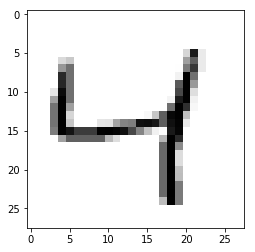

In [45]:
plt.imshow(X_train[2,:,:,0], cmap='Greys')

In [5]:
gan = GAN()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 784)               615440    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 392)               307720    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 392)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 393       
Total params: 923,553
Trainable params: 923,553
Non-trainable params: 

In [7]:
gan.train(X_train, epochs=1000)

/Users/home/miniconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch: 0, [Discriminator :: d_loss: 0.589797], [ Generator :: loss: 0.837001]
epoch: 1, [Discriminator :: d_loss: 0.538260], [ Generator :: loss: 0.719481]
epoch: 2, [Discriminator :: d_loss: 0.555563], [ Generator :: loss: 0.868352]
epoch: 3, [Discriminator :: d_loss: 0.629261], [ Generator :: loss: 0.708873]
epoch: 4, [Discriminator :: d_loss: 0.640923], [ Generator :: loss: 0.790012]
epoch: 5, [Discriminator :: d_loss: 0.563283], [ Generator :: loss: 0.801464]
epoch: 6, [Discriminator :: d_loss: 0.570016], [ Generator :: loss: 0.884506]
epoch: 7, [Discriminator :: d_loss: 0.614675], [ Generator :: loss: 0.779769]
epoch: 8, [Discriminator :: d_loss: 0.703384], [ Generator :: loss: 0.469994]
epoch: 9, [Discriminator :: d_loss: 0.707582], [ Generator :: loss: 0.833680]
epoch: 10, [Discriminator :: d_loss: 0.671392], [ Generator :: loss: 0.720598]
epoch: 11, [Discriminator :: d_loss: 0.721248], [ Generator :: loss: 0.604888]
epoch: 12, [Discriminator :: d_loss: 0.650053], [ Generator ::

epoch: 105, [Discriminator :: d_loss: 0.594290], [ Generator :: loss: 0.708086]
epoch: 106, [Discriminator :: d_loss: 0.580571], [ Generator :: loss: 0.683948]
epoch: 107, [Discriminator :: d_loss: 0.595001], [ Generator :: loss: 0.920803]
epoch: 108, [Discriminator :: d_loss: 0.592136], [ Generator :: loss: 0.553268]
epoch: 109, [Discriminator :: d_loss: 0.641901], [ Generator :: loss: 0.941233]
epoch: 110, [Discriminator :: d_loss: 0.639791], [ Generator :: loss: 0.731838]
epoch: 111, [Discriminator :: d_loss: 0.598339], [ Generator :: loss: 0.674985]
epoch: 112, [Discriminator :: d_loss: 0.629723], [ Generator :: loss: 0.687139]
epoch: 113, [Discriminator :: d_loss: 0.595906], [ Generator :: loss: 1.243357]
epoch: 114, [Discriminator :: d_loss: 0.801069], [ Generator :: loss: 0.280886]
epoch: 115, [Discriminator :: d_loss: 0.807935], [ Generator :: loss: 0.622217]
epoch: 116, [Discriminator :: d_loss: 0.588943], [ Generator :: loss: 1.174670]
epoch: 117, [Discriminator :: d_loss: 0.

epoch: 208, [Discriminator :: d_loss: 0.612623], [ Generator :: loss: 0.595061]
epoch: 209, [Discriminator :: d_loss: 0.595596], [ Generator :: loss: 1.083688]
epoch: 210, [Discriminator :: d_loss: 0.604601], [ Generator :: loss: 0.792874]
epoch: 211, [Discriminator :: d_loss: 0.588774], [ Generator :: loss: 0.855675]
epoch: 212, [Discriminator :: d_loss: 0.584813], [ Generator :: loss: 0.584682]
epoch: 213, [Discriminator :: d_loss: 0.633836], [ Generator :: loss: 0.853764]
epoch: 214, [Discriminator :: d_loss: 0.614460], [ Generator :: loss: 0.700607]
epoch: 215, [Discriminator :: d_loss: 0.591034], [ Generator :: loss: 0.919092]
epoch: 216, [Discriminator :: d_loss: 0.574278], [ Generator :: loss: 0.807875]
epoch: 217, [Discriminator :: d_loss: 0.594786], [ Generator :: loss: 0.716376]
epoch: 218, [Discriminator :: d_loss: 0.578021], [ Generator :: loss: 0.942701]
epoch: 219, [Discriminator :: d_loss: 0.627063], [ Generator :: loss: 0.640697]
epoch: 220, [Discriminator :: d_loss: 0.

epoch: 312, [Discriminator :: d_loss: 0.668311], [ Generator :: loss: 0.554987]
epoch: 313, [Discriminator :: d_loss: 0.576841], [ Generator :: loss: 1.244090]
epoch: 314, [Discriminator :: d_loss: 0.753566], [ Generator :: loss: 0.373919]
epoch: 315, [Discriminator :: d_loss: 0.709850], [ Generator :: loss: 0.890033]
epoch: 316, [Discriminator :: d_loss: 0.570739], [ Generator :: loss: 1.038578]
epoch: 317, [Discriminator :: d_loss: 0.582249], [ Generator :: loss: 0.602781]
epoch: 318, [Discriminator :: d_loss: 0.613328], [ Generator :: loss: 0.827846]
epoch: 319, [Discriminator :: d_loss: 0.615120], [ Generator :: loss: 0.922379]
epoch: 320, [Discriminator :: d_loss: 0.565728], [ Generator :: loss: 0.804049]
epoch: 321, [Discriminator :: d_loss: 0.589239], [ Generator :: loss: 0.642686]
epoch: 322, [Discriminator :: d_loss: 0.643540], [ Generator :: loss: 0.770379]
epoch: 323, [Discriminator :: d_loss: 0.581902], [ Generator :: loss: 0.988578]
epoch: 324, [Discriminator :: d_loss: 0.

epoch: 415, [Discriminator :: d_loss: 0.687937], [ Generator :: loss: 1.127280]
epoch: 416, [Discriminator :: d_loss: 0.645983], [ Generator :: loss: 0.874436]
epoch: 417, [Discriminator :: d_loss: 0.547334], [ Generator :: loss: 0.807832]
epoch: 418, [Discriminator :: d_loss: 0.650144], [ Generator :: loss: 0.521326]
epoch: 419, [Discriminator :: d_loss: 0.648444], [ Generator :: loss: 0.763799]
epoch: 420, [Discriminator :: d_loss: 0.664380], [ Generator :: loss: 0.841352]
epoch: 421, [Discriminator :: d_loss: 0.600432], [ Generator :: loss: 0.779188]
epoch: 422, [Discriminator :: d_loss: 0.615742], [ Generator :: loss: 0.964849]
epoch: 423, [Discriminator :: d_loss: 0.539646], [ Generator :: loss: 0.827726]
epoch: 424, [Discriminator :: d_loss: 0.627558], [ Generator :: loss: 0.700482]
epoch: 425, [Discriminator :: d_loss: 0.649487], [ Generator :: loss: 0.935008]
epoch: 426, [Discriminator :: d_loss: 0.618598], [ Generator :: loss: 0.635887]
epoch: 427, [Discriminator :: d_loss: 0.

epoch: 518, [Discriminator :: d_loss: 0.684941], [ Generator :: loss: 0.977764]
epoch: 519, [Discriminator :: d_loss: 0.611770], [ Generator :: loss: 1.111397]
epoch: 520, [Discriminator :: d_loss: 0.644452], [ Generator :: loss: 0.520304]
epoch: 521, [Discriminator :: d_loss: 0.665160], [ Generator :: loss: 0.933729]
epoch: 522, [Discriminator :: d_loss: 0.617443], [ Generator :: loss: 0.813925]
epoch: 523, [Discriminator :: d_loss: 0.548573], [ Generator :: loss: 0.889525]
epoch: 524, [Discriminator :: d_loss: 0.584451], [ Generator :: loss: 0.691727]
epoch: 525, [Discriminator :: d_loss: 0.637046], [ Generator :: loss: 0.725179]
epoch: 526, [Discriminator :: d_loss: 0.632881], [ Generator :: loss: 0.901898]
epoch: 527, [Discriminator :: d_loss: 0.611364], [ Generator :: loss: 0.740272]
epoch: 528, [Discriminator :: d_loss: 0.586032], [ Generator :: loss: 0.813444]
epoch: 529, [Discriminator :: d_loss: 0.607032], [ Generator :: loss: 0.902266]
epoch: 530, [Discriminator :: d_loss: 0.

epoch: 621, [Discriminator :: d_loss: 0.563469], [ Generator :: loss: 1.012027]
epoch: 622, [Discriminator :: d_loss: 0.477687], [ Generator :: loss: 1.163217]
epoch: 623, [Discriminator :: d_loss: 0.532199], [ Generator :: loss: 0.642180]
epoch: 624, [Discriminator :: d_loss: 0.564277], [ Generator :: loss: 1.109014]
epoch: 625, [Discriminator :: d_loss: 0.576477], [ Generator :: loss: 0.863032]
epoch: 626, [Discriminator :: d_loss: 0.772372], [ Generator :: loss: 0.776408]
epoch: 627, [Discriminator :: d_loss: 0.598046], [ Generator :: loss: 1.142133]
epoch: 628, [Discriminator :: d_loss: 0.677320], [ Generator :: loss: 0.659203]
epoch: 629, [Discriminator :: d_loss: 0.595053], [ Generator :: loss: 0.959979]
epoch: 630, [Discriminator :: d_loss: 0.555435], [ Generator :: loss: 1.124866]
epoch: 631, [Discriminator :: d_loss: 0.469501], [ Generator :: loss: 0.939962]
epoch: 632, [Discriminator :: d_loss: 0.532149], [ Generator :: loss: 0.655725]
epoch: 633, [Discriminator :: d_loss: 0.

epoch: 724, [Discriminator :: d_loss: 0.565437], [ Generator :: loss: 0.829970]
epoch: 725, [Discriminator :: d_loss: 0.535162], [ Generator :: loss: 1.176650]
epoch: 726, [Discriminator :: d_loss: 0.630589], [ Generator :: loss: 0.553781]
epoch: 727, [Discriminator :: d_loss: 0.676852], [ Generator :: loss: 1.180394]
epoch: 728, [Discriminator :: d_loss: 0.662925], [ Generator :: loss: 0.734443]
epoch: 729, [Discriminator :: d_loss: 0.747878], [ Generator :: loss: 0.852203]
epoch: 730, [Discriminator :: d_loss: 0.626656], [ Generator :: loss: 0.821596]
epoch: 731, [Discriminator :: d_loss: 0.548910], [ Generator :: loss: 0.897149]
epoch: 732, [Discriminator :: d_loss: 0.637339], [ Generator :: loss: 0.729653]
epoch: 733, [Discriminator :: d_loss: 0.602045], [ Generator :: loss: 0.833651]
epoch: 734, [Discriminator :: d_loss: 0.567460], [ Generator :: loss: 0.957564]
epoch: 735, [Discriminator :: d_loss: 0.575400], [ Generator :: loss: 0.804759]
epoch: 736, [Discriminator :: d_loss: 0.

epoch: 827, [Discriminator :: d_loss: 0.584820], [ Generator :: loss: 0.927560]
epoch: 828, [Discriminator :: d_loss: 0.621232], [ Generator :: loss: 0.955258]
epoch: 829, [Discriminator :: d_loss: 0.611537], [ Generator :: loss: 0.663656]
epoch: 830, [Discriminator :: d_loss: 0.500285], [ Generator :: loss: 1.021595]
epoch: 831, [Discriminator :: d_loss: 0.498578], [ Generator :: loss: 1.266839]
epoch: 832, [Discriminator :: d_loss: 0.754287], [ Generator :: loss: 0.432264]
epoch: 833, [Discriminator :: d_loss: 0.661073], [ Generator :: loss: 0.924448]
epoch: 834, [Discriminator :: d_loss: 0.539963], [ Generator :: loss: 1.138424]
epoch: 835, [Discriminator :: d_loss: 0.610283], [ Generator :: loss: 0.798663]
epoch: 836, [Discriminator :: d_loss: 0.567909], [ Generator :: loss: 0.626985]
epoch: 837, [Discriminator :: d_loss: 0.609987], [ Generator :: loss: 1.107910]
epoch: 838, [Discriminator :: d_loss: 0.615260], [ Generator :: loss: 1.088706]
epoch: 839, [Discriminator :: d_loss: 0.

epoch: 930, [Discriminator :: d_loss: 0.558252], [ Generator :: loss: 1.302987]
epoch: 931, [Discriminator :: d_loss: 0.674728], [ Generator :: loss: 0.529527]
epoch: 932, [Discriminator :: d_loss: 0.620030], [ Generator :: loss: 0.874046]
epoch: 933, [Discriminator :: d_loss: 0.614161], [ Generator :: loss: 1.098875]
epoch: 934, [Discriminator :: d_loss: 0.493451], [ Generator :: loss: 1.017773]
epoch: 935, [Discriminator :: d_loss: 0.568251], [ Generator :: loss: 0.712862]
epoch: 936, [Discriminator :: d_loss: 0.614532], [ Generator :: loss: 0.728878]
epoch: 937, [Discriminator :: d_loss: 0.557145], [ Generator :: loss: 1.178550]
epoch: 938, [Discriminator :: d_loss: 0.584045], [ Generator :: loss: 1.119331]
epoch: 939, [Discriminator :: d_loss: 0.595295], [ Generator :: loss: 0.667830]
epoch: 940, [Discriminator :: d_loss: 0.544476], [ Generator :: loss: 0.826660]
epoch: 941, [Discriminator :: d_loss: 0.590449], [ Generator :: loss: 0.851663]
epoch: 942, [Discriminator :: d_loss: 0.

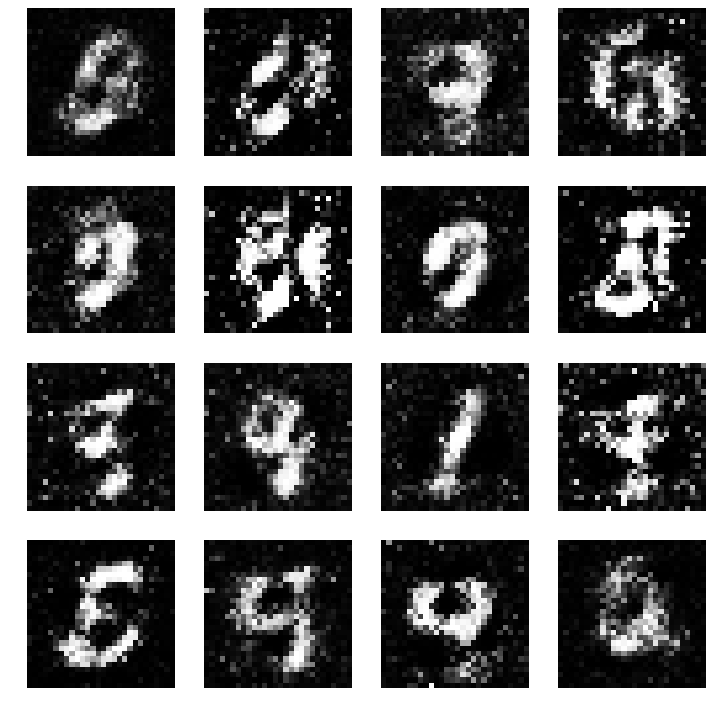

In [8]:
gan.plot_images()

In [9]:
gan_1 = GAN()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 784)               615440    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 784)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 392)               307720    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 392)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 393       
Total params: 923,553
Trainable params: 923,553
Non-trainable params: 0
_________________________________________________________________


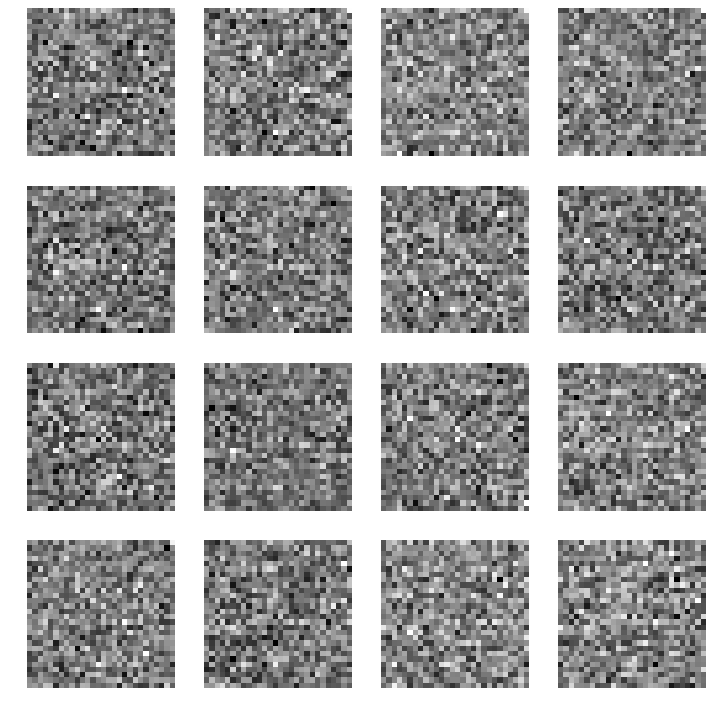

In [10]:
gan_1.plot_images()

In [16]:
gan_1.train(X_train, epochs=1000)

epoch: 0, [Discriminator :: d_loss: 0.006147], [ Generator :: loss: 5.081326]
epoch: 1, [Discriminator :: d_loss: 0.010443], [ Generator :: loss: 4.862057]
epoch: 2, [Discriminator :: d_loss: 0.016069], [ Generator :: loss: 4.883730]
epoch: 3, [Discriminator :: d_loss: 0.012571], [ Generator :: loss: 5.094636]
epoch: 4, [Discriminator :: d_loss: 0.012076], [ Generator :: loss: 5.267970]
epoch: 5, [Discriminator :: d_loss: 0.008900], [ Generator :: loss: 5.104585]
epoch: 6, [Discriminator :: d_loss: 0.014116], [ Generator :: loss: 5.038375]
epoch: 7, [Discriminator :: d_loss: 0.009419], [ Generator :: loss: 5.023947]
epoch: 8, [Discriminator :: d_loss: 0.011733], [ Generator :: loss: 5.017753]
epoch: 9, [Discriminator :: d_loss: 0.026762], [ Generator :: loss: 5.335884]
epoch: 10, [Discriminator :: d_loss: 0.013924], [ Generator :: loss: 5.239514]
epoch: 11, [Discriminator :: d_loss: 0.021225], [ Generator :: loss: 5.336374]
epoch: 12, [Discriminator :: d_loss: 0.006615], [ Generator ::

epoch: 105, [Discriminator :: d_loss: 0.063354], [ Generator :: loss: 3.032302]
epoch: 106, [Discriminator :: d_loss: 0.154570], [ Generator :: loss: 3.979433]
epoch: 107, [Discriminator :: d_loss: 0.146800], [ Generator :: loss: 2.965533]
epoch: 108, [Discriminator :: d_loss: 0.115354], [ Generator :: loss: 3.434004]
epoch: 109, [Discriminator :: d_loss: 0.207970], [ Generator :: loss: 3.175605]
epoch: 110, [Discriminator :: d_loss: 0.222083], [ Generator :: loss: 2.778271]
epoch: 111, [Discriminator :: d_loss: 0.238554], [ Generator :: loss: 4.756752]
epoch: 112, [Discriminator :: d_loss: 0.372126], [ Generator :: loss: 0.663549]
epoch: 113, [Discriminator :: d_loss: 0.878705], [ Generator :: loss: 1.151815]
epoch: 114, [Discriminator :: d_loss: 0.546536], [ Generator :: loss: 3.709922]
epoch: 115, [Discriminator :: d_loss: 0.145861], [ Generator :: loss: 5.422053]
epoch: 116, [Discriminator :: d_loss: 0.315175], [ Generator :: loss: 1.501061]
epoch: 117, [Discriminator :: d_loss: 0.

epoch: 208, [Discriminator :: d_loss: 0.557268], [ Generator :: loss: 0.860682]
epoch: 209, [Discriminator :: d_loss: 0.612493], [ Generator :: loss: 0.551870]
epoch: 210, [Discriminator :: d_loss: 0.645175], [ Generator :: loss: 0.791705]
epoch: 211, [Discriminator :: d_loss: 0.665155], [ Generator :: loss: 0.882134]
epoch: 212, [Discriminator :: d_loss: 0.562821], [ Generator :: loss: 0.786935]
epoch: 213, [Discriminator :: d_loss: 0.604587], [ Generator :: loss: 0.693567]
epoch: 214, [Discriminator :: d_loss: 0.554074], [ Generator :: loss: 0.730849]
epoch: 215, [Discriminator :: d_loss: 0.564043], [ Generator :: loss: 0.888337]
epoch: 216, [Discriminator :: d_loss: 0.560404], [ Generator :: loss: 0.838242]
epoch: 217, [Discriminator :: d_loss: 0.527424], [ Generator :: loss: 0.942247]
epoch: 218, [Discriminator :: d_loss: 0.637117], [ Generator :: loss: 0.623089]
epoch: 219, [Discriminator :: d_loss: 0.635237], [ Generator :: loss: 0.820391]
epoch: 220, [Discriminator :: d_loss: 0.

epoch: 311, [Discriminator :: d_loss: 0.643037], [ Generator :: loss: 0.626497]
epoch: 312, [Discriminator :: d_loss: 0.620680], [ Generator :: loss: 0.977714]
epoch: 313, [Discriminator :: d_loss: 0.690011], [ Generator :: loss: 0.602444]
epoch: 314, [Discriminator :: d_loss: 0.661326], [ Generator :: loss: 0.626115]
epoch: 315, [Discriminator :: d_loss: 0.686809], [ Generator :: loss: 0.767133]
epoch: 316, [Discriminator :: d_loss: 0.675231], [ Generator :: loss: 0.646918]
epoch: 317, [Discriminator :: d_loss: 0.632343], [ Generator :: loss: 0.859770]
epoch: 318, [Discriminator :: d_loss: 0.667850], [ Generator :: loss: 0.725013]
epoch: 319, [Discriminator :: d_loss: 0.633581], [ Generator :: loss: 0.479805]
epoch: 320, [Discriminator :: d_loss: 0.640554], [ Generator :: loss: 1.055752]
epoch: 321, [Discriminator :: d_loss: 0.748181], [ Generator :: loss: 0.593494]
epoch: 322, [Discriminator :: d_loss: 0.662639], [ Generator :: loss: 0.679523]
epoch: 323, [Discriminator :: d_loss: 0.

epoch: 414, [Discriminator :: d_loss: 0.596590], [ Generator :: loss: 0.539768]
epoch: 415, [Discriminator :: d_loss: 0.624866], [ Generator :: loss: 1.266657]
epoch: 416, [Discriminator :: d_loss: 0.651365], [ Generator :: loss: 0.444606]
epoch: 417, [Discriminator :: d_loss: 0.673564], [ Generator :: loss: 0.945567]
epoch: 418, [Discriminator :: d_loss: 0.689104], [ Generator :: loss: 0.620706]
epoch: 419, [Discriminator :: d_loss: 0.578872], [ Generator :: loss: 0.846947]
epoch: 420, [Discriminator :: d_loss: 0.577869], [ Generator :: loss: 0.986076]
epoch: 421, [Discriminator :: d_loss: 0.604319], [ Generator :: loss: 0.603158]
epoch: 422, [Discriminator :: d_loss: 0.637964], [ Generator :: loss: 0.797589]
epoch: 423, [Discriminator :: d_loss: 0.582503], [ Generator :: loss: 0.951617]
epoch: 424, [Discriminator :: d_loss: 0.689779], [ Generator :: loss: 0.395775]
epoch: 425, [Discriminator :: d_loss: 0.718261], [ Generator :: loss: 0.929397]
epoch: 426, [Discriminator :: d_loss: 0.

epoch: 517, [Discriminator :: d_loss: 0.559421], [ Generator :: loss: 0.869523]
epoch: 518, [Discriminator :: d_loss: 0.604807], [ Generator :: loss: 0.738912]
epoch: 519, [Discriminator :: d_loss: 0.627071], [ Generator :: loss: 0.873700]
epoch: 520, [Discriminator :: d_loss: 0.564279], [ Generator :: loss: 0.862596]
epoch: 521, [Discriminator :: d_loss: 0.592635], [ Generator :: loss: 0.808114]
epoch: 522, [Discriminator :: d_loss: 0.604053], [ Generator :: loss: 0.787764]
epoch: 523, [Discriminator :: d_loss: 0.604727], [ Generator :: loss: 0.905287]
epoch: 524, [Discriminator :: d_loss: 0.640782], [ Generator :: loss: 0.667084]
epoch: 525, [Discriminator :: d_loss: 0.579370], [ Generator :: loss: 0.792169]
epoch: 526, [Discriminator :: d_loss: 0.557725], [ Generator :: loss: 0.837522]
epoch: 527, [Discriminator :: d_loss: 0.578225], [ Generator :: loss: 0.639428]
epoch: 528, [Discriminator :: d_loss: 0.611789], [ Generator :: loss: 1.110380]
epoch: 529, [Discriminator :: d_loss: 0.

epoch: 620, [Discriminator :: d_loss: 0.571000], [ Generator :: loss: 1.178624]
epoch: 621, [Discriminator :: d_loss: 0.591940], [ Generator :: loss: 0.786508]
epoch: 622, [Discriminator :: d_loss: 0.576781], [ Generator :: loss: 0.674846]
epoch: 623, [Discriminator :: d_loss: 0.540121], [ Generator :: loss: 1.000874]
epoch: 624, [Discriminator :: d_loss: 0.560155], [ Generator :: loss: 0.791426]
epoch: 625, [Discriminator :: d_loss: 0.579518], [ Generator :: loss: 0.814655]
epoch: 626, [Discriminator :: d_loss: 0.618213], [ Generator :: loss: 0.659706]
epoch: 627, [Discriminator :: d_loss: 0.655141], [ Generator :: loss: 0.892385]
epoch: 628, [Discriminator :: d_loss: 0.621847], [ Generator :: loss: 0.729306]
epoch: 629, [Discriminator :: d_loss: 0.595015], [ Generator :: loss: 0.984797]
epoch: 630, [Discriminator :: d_loss: 0.597976], [ Generator :: loss: 0.740982]
epoch: 631, [Discriminator :: d_loss: 0.621693], [ Generator :: loss: 1.067641]
epoch: 632, [Discriminator :: d_loss: 0.

epoch: 723, [Discriminator :: d_loss: 0.601663], [ Generator :: loss: 0.810898]
epoch: 724, [Discriminator :: d_loss: 0.538839], [ Generator :: loss: 0.901772]
epoch: 725, [Discriminator :: d_loss: 0.628492], [ Generator :: loss: 0.608037]
epoch: 726, [Discriminator :: d_loss: 0.582163], [ Generator :: loss: 0.843968]
epoch: 727, [Discriminator :: d_loss: 0.539145], [ Generator :: loss: 0.802839]
epoch: 728, [Discriminator :: d_loss: 0.612859], [ Generator :: loss: 0.717634]
epoch: 729, [Discriminator :: d_loss: 0.624286], [ Generator :: loss: 1.007610]
epoch: 730, [Discriminator :: d_loss: 0.564803], [ Generator :: loss: 0.794679]
epoch: 731, [Discriminator :: d_loss: 0.597000], [ Generator :: loss: 0.798183]
epoch: 732, [Discriminator :: d_loss: 0.551385], [ Generator :: loss: 0.963679]
epoch: 733, [Discriminator :: d_loss: 0.544615], [ Generator :: loss: 0.833528]
epoch: 734, [Discriminator :: d_loss: 0.573581], [ Generator :: loss: 0.769456]
epoch: 735, [Discriminator :: d_loss: 0.

epoch: 826, [Discriminator :: d_loss: 0.622696], [ Generator :: loss: 0.739019]
epoch: 827, [Discriminator :: d_loss: 0.567292], [ Generator :: loss: 0.841860]
epoch: 828, [Discriminator :: d_loss: 0.639556], [ Generator :: loss: 0.829613]
epoch: 829, [Discriminator :: d_loss: 0.676404], [ Generator :: loss: 0.823029]
epoch: 830, [Discriminator :: d_loss: 0.613837], [ Generator :: loss: 0.773837]
epoch: 831, [Discriminator :: d_loss: 0.631010], [ Generator :: loss: 0.865815]
epoch: 832, [Discriminator :: d_loss: 0.612492], [ Generator :: loss: 0.609563]
epoch: 833, [Discriminator :: d_loss: 0.620609], [ Generator :: loss: 0.961319]
epoch: 834, [Discriminator :: d_loss: 0.599495], [ Generator :: loss: 0.740701]
epoch: 835, [Discriminator :: d_loss: 0.642048], [ Generator :: loss: 0.675297]
epoch: 836, [Discriminator :: d_loss: 0.633130], [ Generator :: loss: 0.940499]
epoch: 837, [Discriminator :: d_loss: 0.600022], [ Generator :: loss: 0.752712]
epoch: 838, [Discriminator :: d_loss: 0.

epoch: 929, [Discriminator :: d_loss: 0.606046], [ Generator :: loss: 0.853371]
epoch: 930, [Discriminator :: d_loss: 0.599276], [ Generator :: loss: 0.651563]
epoch: 931, [Discriminator :: d_loss: 0.647291], [ Generator :: loss: 0.859539]
epoch: 932, [Discriminator :: d_loss: 0.569139], [ Generator :: loss: 1.137713]
epoch: 933, [Discriminator :: d_loss: 0.648561], [ Generator :: loss: 0.539519]
epoch: 934, [Discriminator :: d_loss: 0.620603], [ Generator :: loss: 1.119895]
epoch: 935, [Discriminator :: d_loss: 0.631308], [ Generator :: loss: 0.518783]
epoch: 936, [Discriminator :: d_loss: 0.620932], [ Generator :: loss: 1.158082]
epoch: 937, [Discriminator :: d_loss: 0.619042], [ Generator :: loss: 0.968082]
epoch: 938, [Discriminator :: d_loss: 0.684055], [ Generator :: loss: 0.697208]
epoch: 939, [Discriminator :: d_loss: 0.608455], [ Generator :: loss: 0.805701]
epoch: 940, [Discriminator :: d_loss: 0.568675], [ Generator :: loss: 0.878424]
epoch: 941, [Discriminator :: d_loss: 0.

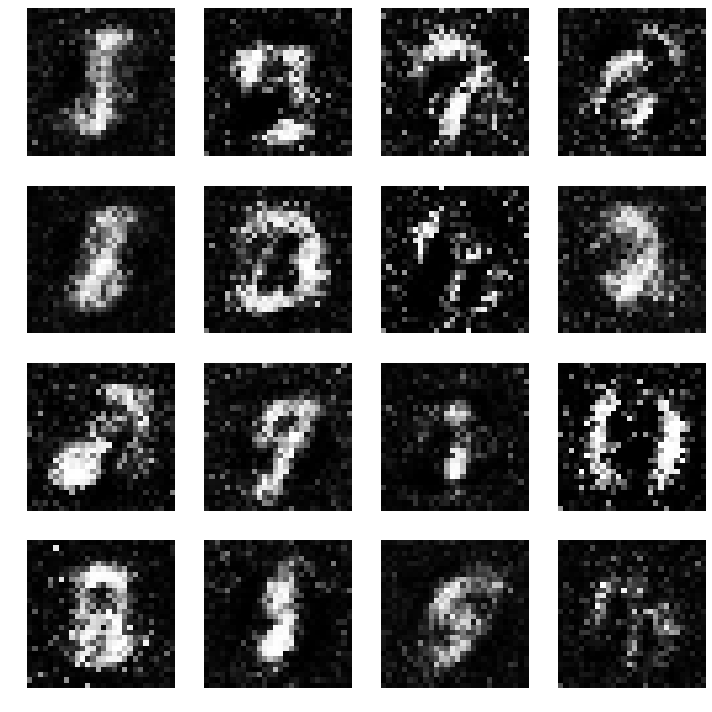

In [17]:
gan_1.plot_images()

In [20]:
gan_2 = GAN()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 784)               615440    
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 784)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 392)               307720    
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 392)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 393       
Total params: 923,553
Trainable params: 923,553
Non-trainable params: 0
_________________________________________________________________


In [23]:
gan_2.train(X_train, epochs=1000)

/Users/home/miniconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch: 0, [Discriminator :: d_loss: 0.018955], [ Generator :: loss: 5.070044]
epoch: 1, [Discriminator :: d_loss: 0.008088], [ Generator :: loss: 5.129551]
epoch: 2, [Discriminator :: d_loss: 0.015358], [ Generator :: loss: 5.382919]
epoch: 3, [Discriminator :: d_loss: 0.012760], [ Generator :: loss: 5.379216]
epoch: 4, [Discriminator :: d_loss: 0.013686], [ Generator :: loss: 4.987697]
epoch: 5, [Discriminator :: d_loss: 0.010875], [ Generator :: loss: 4.946860]
epoch: 6, [Discriminator :: d_loss: 0.014870], [ Generator :: loss: 4.932598]
epoch: 7, [Discriminator :: d_loss: 0.011496], [ Generator :: loss: 5.152799]
epoch: 8, [Discriminator :: d_loss: 0.006851], [ Generator :: loss: 5.161691]
epoch: 9, [Discriminator :: d_loss: 0.005288], [ Generator :: loss: 4.983068]
epoch: 10, [Discriminator :: d_loss: 0.022057], [ Generator :: loss: 5.481162]
epoch: 11, [Discriminator :: d_loss: 0.013172], [ Generator :: loss: 5.448226]
epoch: 12, [Discriminator :: d_loss: 0.017510], [ Generator ::

epoch: 105, [Discriminator :: d_loss: 0.484688], [ Generator :: loss: 0.895327]
epoch: 106, [Discriminator :: d_loss: 1.069517], [ Generator :: loss: 0.718613]
epoch: 107, [Discriminator :: d_loss: 0.749712], [ Generator :: loss: 2.581390]
epoch: 108, [Discriminator :: d_loss: 0.118587], [ Generator :: loss: 4.623758]
epoch: 109, [Discriminator :: d_loss: 0.152401], [ Generator :: loss: 4.713132]
epoch: 110, [Discriminator :: d_loss: 0.238736], [ Generator :: loss: 2.687042]
epoch: 111, [Discriminator :: d_loss: 0.123955], [ Generator :: loss: 2.153023]
epoch: 112, [Discriminator :: d_loss: 0.244677], [ Generator :: loss: 3.331729]
epoch: 113, [Discriminator :: d_loss: 0.112863], [ Generator :: loss: 3.152297]
epoch: 114, [Discriminator :: d_loss: 0.145460], [ Generator :: loss: 3.293539]
epoch: 115, [Discriminator :: d_loss: 0.248403], [ Generator :: loss: 3.253593]
epoch: 116, [Discriminator :: d_loss: 0.174837], [ Generator :: loss: 2.332101]
epoch: 117, [Discriminator :: d_loss: 0.

epoch: 208, [Discriminator :: d_loss: 0.542491], [ Generator :: loss: 0.833096]
epoch: 209, [Discriminator :: d_loss: 0.552970], [ Generator :: loss: 0.780318]
epoch: 210, [Discriminator :: d_loss: 0.647572], [ Generator :: loss: 0.644759]
epoch: 211, [Discriminator :: d_loss: 0.638737], [ Generator :: loss: 0.745639]
epoch: 212, [Discriminator :: d_loss: 0.573643], [ Generator :: loss: 1.068149]
epoch: 213, [Discriminator :: d_loss: 0.661939], [ Generator :: loss: 0.589079]
epoch: 214, [Discriminator :: d_loss: 0.647372], [ Generator :: loss: 0.743596]
epoch: 215, [Discriminator :: d_loss: 0.625155], [ Generator :: loss: 0.894558]
epoch: 216, [Discriminator :: d_loss: 0.659443], [ Generator :: loss: 0.573914]
epoch: 217, [Discriminator :: d_loss: 0.644077], [ Generator :: loss: 0.889912]
epoch: 218, [Discriminator :: d_loss: 0.639692], [ Generator :: loss: 0.776774]
epoch: 219, [Discriminator :: d_loss: 0.578291], [ Generator :: loss: 0.798422]
epoch: 220, [Discriminator :: d_loss: 0.

epoch: 311, [Discriminator :: d_loss: 0.587637], [ Generator :: loss: 0.858471]
epoch: 312, [Discriminator :: d_loss: 0.577108], [ Generator :: loss: 0.675251]
epoch: 313, [Discriminator :: d_loss: 0.630767], [ Generator :: loss: 0.825517]
epoch: 314, [Discriminator :: d_loss: 0.699862], [ Generator :: loss: 0.700919]
epoch: 315, [Discriminator :: d_loss: 0.630420], [ Generator :: loss: 0.887283]
epoch: 316, [Discriminator :: d_loss: 0.584957], [ Generator :: loss: 0.706727]
epoch: 317, [Discriminator :: d_loss: 0.564226], [ Generator :: loss: 0.971372]
epoch: 318, [Discriminator :: d_loss: 0.551710], [ Generator :: loss: 0.793474]
epoch: 319, [Discriminator :: d_loss: 0.554581], [ Generator :: loss: 0.874267]
epoch: 320, [Discriminator :: d_loss: 0.624670], [ Generator :: loss: 0.631346]
epoch: 321, [Discriminator :: d_loss: 0.639041], [ Generator :: loss: 0.965809]
epoch: 322, [Discriminator :: d_loss: 0.758322], [ Generator :: loss: 0.382381]
epoch: 323, [Discriminator :: d_loss: 0.

epoch: 415, [Discriminator :: d_loss: 0.672322], [ Generator :: loss: 0.584707]
epoch: 416, [Discriminator :: d_loss: 0.590564], [ Generator :: loss: 0.654433]
epoch: 417, [Discriminator :: d_loss: 0.582038], [ Generator :: loss: 1.167278]
epoch: 418, [Discriminator :: d_loss: 0.536722], [ Generator :: loss: 0.927640]
epoch: 419, [Discriminator :: d_loss: 0.517403], [ Generator :: loss: 0.766647]
epoch: 420, [Discriminator :: d_loss: 0.580691], [ Generator :: loss: 0.966084]
epoch: 421, [Discriminator :: d_loss: 0.552384], [ Generator :: loss: 1.030178]
epoch: 422, [Discriminator :: d_loss: 0.538413], [ Generator :: loss: 0.819650]
epoch: 423, [Discriminator :: d_loss: 0.569844], [ Generator :: loss: 0.805410]
epoch: 424, [Discriminator :: d_loss: 0.653244], [ Generator :: loss: 0.724371]
epoch: 425, [Discriminator :: d_loss: 0.644965], [ Generator :: loss: 0.770220]
epoch: 426, [Discriminator :: d_loss: 0.612358], [ Generator :: loss: 1.212362]
epoch: 427, [Discriminator :: d_loss: 0.

epoch: 518, [Discriminator :: d_loss: 0.543871], [ Generator :: loss: 1.116372]
epoch: 519, [Discriminator :: d_loss: 0.564265], [ Generator :: loss: 0.461613]
epoch: 520, [Discriminator :: d_loss: 0.662415], [ Generator :: loss: 1.084894]
epoch: 521, [Discriminator :: d_loss: 0.581667], [ Generator :: loss: 0.879659]
epoch: 522, [Discriminator :: d_loss: 0.559784], [ Generator :: loss: 0.785951]
epoch: 523, [Discriminator :: d_loss: 0.534651], [ Generator :: loss: 1.036198]
epoch: 524, [Discriminator :: d_loss: 0.596817], [ Generator :: loss: 0.602471]
epoch: 525, [Discriminator :: d_loss: 0.703983], [ Generator :: loss: 1.035922]
epoch: 526, [Discriminator :: d_loss: 0.638984], [ Generator :: loss: 0.764791]
epoch: 527, [Discriminator :: d_loss: 0.608182], [ Generator :: loss: 0.993029]
epoch: 528, [Discriminator :: d_loss: 0.585821], [ Generator :: loss: 0.762945]
epoch: 529, [Discriminator :: d_loss: 0.608995], [ Generator :: loss: 0.938310]
epoch: 530, [Discriminator :: d_loss: 0.

epoch: 621, [Discriminator :: d_loss: 0.599687], [ Generator :: loss: 0.847263]
epoch: 622, [Discriminator :: d_loss: 0.639389], [ Generator :: loss: 0.996689]
epoch: 623, [Discriminator :: d_loss: 0.547829], [ Generator :: loss: 0.788085]
epoch: 624, [Discriminator :: d_loss: 0.575548], [ Generator :: loss: 0.786046]
epoch: 625, [Discriminator :: d_loss: 0.590826], [ Generator :: loss: 1.307125]
epoch: 626, [Discriminator :: d_loss: 0.655978], [ Generator :: loss: 0.582173]
epoch: 627, [Discriminator :: d_loss: 0.546755], [ Generator :: loss: 1.113844]
epoch: 628, [Discriminator :: d_loss: 0.610516], [ Generator :: loss: 0.722982]
epoch: 629, [Discriminator :: d_loss: 0.624237], [ Generator :: loss: 0.784039]
epoch: 630, [Discriminator :: d_loss: 0.662235], [ Generator :: loss: 0.698736]
epoch: 631, [Discriminator :: d_loss: 0.574172], [ Generator :: loss: 1.044083]
epoch: 632, [Discriminator :: d_loss: 0.751924], [ Generator :: loss: 0.642342]
epoch: 633, [Discriminator :: d_loss: 0.

epoch: 724, [Discriminator :: d_loss: 0.470530], [ Generator :: loss: 1.373244]
epoch: 725, [Discriminator :: d_loss: 0.749511], [ Generator :: loss: 0.300832]
epoch: 726, [Discriminator :: d_loss: 0.850696], [ Generator :: loss: 1.021811]
epoch: 727, [Discriminator :: d_loss: 0.649113], [ Generator :: loss: 0.929797]
epoch: 728, [Discriminator :: d_loss: 0.529358], [ Generator :: loss: 0.951898]
epoch: 729, [Discriminator :: d_loss: 0.551055], [ Generator :: loss: 0.873614]
epoch: 730, [Discriminator :: d_loss: 0.605764], [ Generator :: loss: 0.723669]
epoch: 731, [Discriminator :: d_loss: 0.621826], [ Generator :: loss: 1.082823]
epoch: 732, [Discriminator :: d_loss: 0.573849], [ Generator :: loss: 0.966287]
epoch: 733, [Discriminator :: d_loss: 0.590026], [ Generator :: loss: 0.781245]
epoch: 734, [Discriminator :: d_loss: 0.536670], [ Generator :: loss: 0.920302]
epoch: 735, [Discriminator :: d_loss: 0.613440], [ Generator :: loss: 0.757663]
epoch: 736, [Discriminator :: d_loss: 0.

epoch: 827, [Discriminator :: d_loss: 0.661912], [ Generator :: loss: 0.487739]
epoch: 828, [Discriminator :: d_loss: 0.674877], [ Generator :: loss: 1.064713]
epoch: 829, [Discriminator :: d_loss: 0.564378], [ Generator :: loss: 0.959953]
epoch: 830, [Discriminator :: d_loss: 0.560335], [ Generator :: loss: 0.893196]
epoch: 831, [Discriminator :: d_loss: 0.574786], [ Generator :: loss: 0.835323]
epoch: 832, [Discriminator :: d_loss: 0.585901], [ Generator :: loss: 0.843316]
epoch: 833, [Discriminator :: d_loss: 0.575096], [ Generator :: loss: 0.929906]
epoch: 834, [Discriminator :: d_loss: 0.580522], [ Generator :: loss: 0.928074]
epoch: 835, [Discriminator :: d_loss: 0.648116], [ Generator :: loss: 0.593081]
epoch: 836, [Discriminator :: d_loss: 0.599808], [ Generator :: loss: 1.482446]
epoch: 837, [Discriminator :: d_loss: 0.628726], [ Generator :: loss: 0.744602]
epoch: 838, [Discriminator :: d_loss: 0.509707], [ Generator :: loss: 0.956464]
epoch: 839, [Discriminator :: d_loss: 0.

epoch: 930, [Discriminator :: d_loss: 0.614994], [ Generator :: loss: 1.053862]
epoch: 931, [Discriminator :: d_loss: 0.535918], [ Generator :: loss: 1.189508]
epoch: 932, [Discriminator :: d_loss: 0.592871], [ Generator :: loss: 0.497255]
epoch: 933, [Discriminator :: d_loss: 0.754497], [ Generator :: loss: 1.478158]
epoch: 934, [Discriminator :: d_loss: 0.755977], [ Generator :: loss: 0.584660]
epoch: 935, [Discriminator :: d_loss: 0.627552], [ Generator :: loss: 0.877000]
epoch: 936, [Discriminator :: d_loss: 0.611813], [ Generator :: loss: 1.079390]
epoch: 937, [Discriminator :: d_loss: 0.682525], [ Generator :: loss: 0.761337]
epoch: 938, [Discriminator :: d_loss: 0.602079], [ Generator :: loss: 0.776116]
epoch: 939, [Discriminator :: d_loss: 0.645329], [ Generator :: loss: 1.029073]
epoch: 940, [Discriminator :: d_loss: 0.609047], [ Generator :: loss: 0.919507]
epoch: 941, [Discriminator :: d_loss: 0.585142], [ Generator :: loss: 0.753602]
epoch: 942, [Discriminator :: d_loss: 0.

Text(0, 0.5, 'loss')

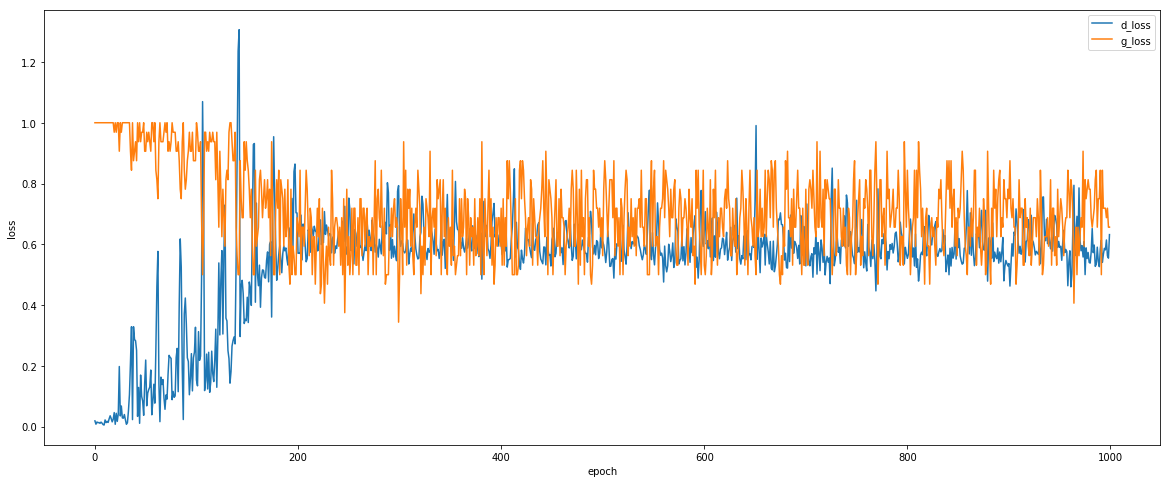

In [51]:
plt.figure(figsize=(20, 8))
plt.plot(gan_2.list_d_loss)
plt.legend(['d_loss', 'g_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')

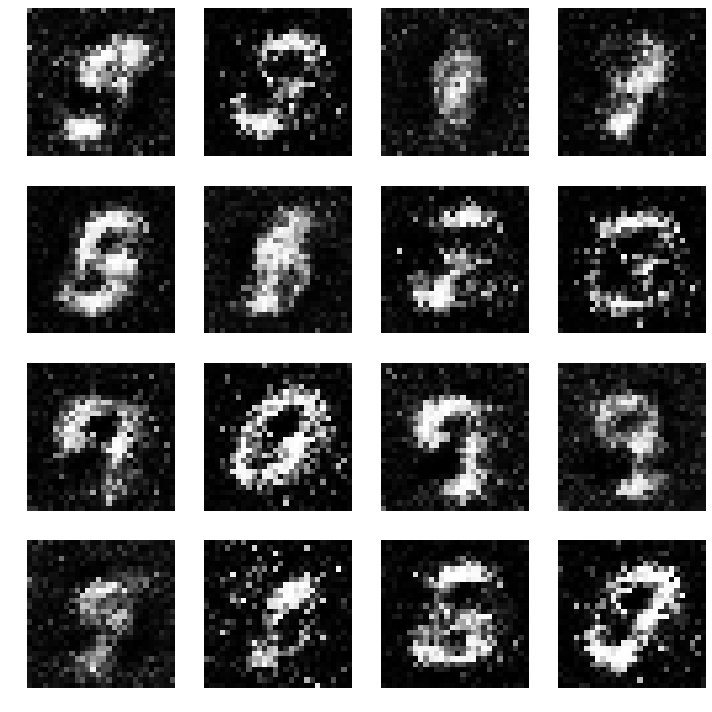

In [30]:
gan_2.plot_images()

In [52]:
tower = np.load("full_numpy_bitmap_The Eiffel Tower.npy")

In [53]:
tower.shape

(134801, 784)

In [55]:
tower_reshape = tower.reshape(134801, 28, 28, 1)

In [57]:
tower_reshape.shape

(134801, 28, 28, 1)

In [66]:
tower_train = tower_reshape[0:6000, :, :, :]

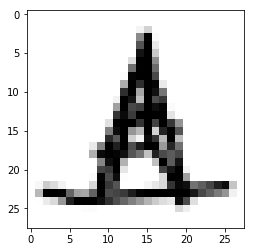

In [73]:
plt.imshow(tower_train[0,:,:,0], cmap="Greys")

In [67]:
gan_tower = GAN()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 784)               615440    
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 784)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 392)               307720    
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 392)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 393       
Total params: 923,553
Trainable params: 923,553
Non-trainable params: 0
_________________________________________________________________


In [68]:
gan_tower.train(tower_train, epochs=1000)

/Users/home/miniconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch: 0, [Discriminator :: d_loss: 3.021968], [ Generator :: loss: 0.784747]
epoch: 1, [Discriminator :: d_loss: 0.368505], [ Generator :: loss: 0.731174]
epoch: 2, [Discriminator :: d_loss: 0.360669], [ Generator :: loss: 0.792153]
epoch: 3, [Discriminator :: d_loss: 0.352939], [ Generator :: loss: 0.799780]
epoch: 4, [Discriminator :: d_loss: 0.320541], [ Generator :: loss: 0.803722]
epoch: 5, [Discriminator :: d_loss: 0.313236], [ Generator :: loss: 0.894310]
epoch: 6, [Discriminator :: d_loss: 0.303843], [ Generator :: loss: 0.863533]
epoch: 7, [Discriminator :: d_loss: 0.275611], [ Generator :: loss: 0.932007]
epoch: 8, [Discriminator :: d_loss: 0.259590], [ Generator :: loss: 1.008583]
epoch: 9, [Discriminator :: d_loss: 0.433221], [ Generator :: loss: 0.952020]
epoch: 10, [Discriminator :: d_loss: 0.269575], [ Generator :: loss: 0.887837]
epoch: 11, [Discriminator :: d_loss: 0.319517], [ Generator :: loss: 0.916776]
epoch: 12, [Discriminator :: d_loss: 0.298183], [ Generator ::

epoch: 105, [Discriminator :: d_loss: 0.172555], [ Generator :: loss: 1.996052]
epoch: 106, [Discriminator :: d_loss: 0.119465], [ Generator :: loss: 1.953933]
epoch: 107, [Discriminator :: d_loss: 0.128854], [ Generator :: loss: 2.016698]
epoch: 108, [Discriminator :: d_loss: 0.114835], [ Generator :: loss: 1.864649]
epoch: 109, [Discriminator :: d_loss: 0.172867], [ Generator :: loss: 1.822179]
epoch: 110, [Discriminator :: d_loss: 0.645029], [ Generator :: loss: 2.131514]
epoch: 111, [Discriminator :: d_loss: 0.107123], [ Generator :: loss: 1.906673]
epoch: 112, [Discriminator :: d_loss: 0.270535], [ Generator :: loss: 2.064598]
epoch: 113, [Discriminator :: d_loss: 0.198974], [ Generator :: loss: 2.089677]
epoch: 114, [Discriminator :: d_loss: 0.127886], [ Generator :: loss: 2.145460]
epoch: 115, [Discriminator :: d_loss: 0.586735], [ Generator :: loss: 2.224048]
epoch: 116, [Discriminator :: d_loss: 0.165436], [ Generator :: loss: 1.981513]
epoch: 117, [Discriminator :: d_loss: 0.

epoch: 209, [Discriminator :: d_loss: 1.701389], [ Generator :: loss: 0.312692]
epoch: 210, [Discriminator :: d_loss: 1.055290], [ Generator :: loss: 0.576207]
epoch: 211, [Discriminator :: d_loss: 0.761017], [ Generator :: loss: 0.843364]
epoch: 212, [Discriminator :: d_loss: 0.705240], [ Generator :: loss: 1.019325]
epoch: 213, [Discriminator :: d_loss: 0.798426], [ Generator :: loss: 1.450799]
epoch: 214, [Discriminator :: d_loss: 0.581781], [ Generator :: loss: 1.204285]
epoch: 215, [Discriminator :: d_loss: 0.539414], [ Generator :: loss: 1.553615]
epoch: 216, [Discriminator :: d_loss: 1.063864], [ Generator :: loss: 1.338688]
epoch: 217, [Discriminator :: d_loss: 2.429716], [ Generator :: loss: 1.516300]
epoch: 218, [Discriminator :: d_loss: 1.429736], [ Generator :: loss: 1.479239]
epoch: 219, [Discriminator :: d_loss: 0.859180], [ Generator :: loss: 0.817762]
epoch: 220, [Discriminator :: d_loss: 2.144675], [ Generator :: loss: 0.546455]
epoch: 221, [Discriminator :: d_loss: 0.

epoch: 313, [Discriminator :: d_loss: 2.497264], [ Generator :: loss: 0.037980]
epoch: 314, [Discriminator :: d_loss: 1.913242], [ Generator :: loss: 0.087262]
epoch: 315, [Discriminator :: d_loss: 1.849442], [ Generator :: loss: 0.211194]
epoch: 316, [Discriminator :: d_loss: 1.017994], [ Generator :: loss: 0.355479]
epoch: 317, [Discriminator :: d_loss: 0.981684], [ Generator :: loss: 0.596460]
epoch: 318, [Discriminator :: d_loss: 0.706915], [ Generator :: loss: 0.784450]
epoch: 319, [Discriminator :: d_loss: 0.421689], [ Generator :: loss: 0.908001]
epoch: 320, [Discriminator :: d_loss: 0.561516], [ Generator :: loss: 0.976729]
epoch: 321, [Discriminator :: d_loss: 0.463143], [ Generator :: loss: 0.978126]
epoch: 322, [Discriminator :: d_loss: 0.660933], [ Generator :: loss: 0.883267]
epoch: 323, [Discriminator :: d_loss: 0.559364], [ Generator :: loss: 1.019104]
epoch: 324, [Discriminator :: d_loss: 0.682765], [ Generator :: loss: 1.074789]
epoch: 325, [Discriminator :: d_loss: 0.

epoch: 417, [Discriminator :: d_loss: 1.078058], [ Generator :: loss: 0.372318]
epoch: 418, [Discriminator :: d_loss: 1.531314], [ Generator :: loss: 0.529822]
epoch: 419, [Discriminator :: d_loss: 0.658857], [ Generator :: loss: 0.605513]
epoch: 420, [Discriminator :: d_loss: 0.497695], [ Generator :: loss: 0.815285]
epoch: 421, [Discriminator :: d_loss: 0.469679], [ Generator :: loss: 0.859330]
epoch: 422, [Discriminator :: d_loss: 1.029062], [ Generator :: loss: 0.990314]
epoch: 423, [Discriminator :: d_loss: 0.878890], [ Generator :: loss: 1.035868]
epoch: 424, [Discriminator :: d_loss: 0.329210], [ Generator :: loss: 1.022099]
epoch: 425, [Discriminator :: d_loss: 0.903496], [ Generator :: loss: 1.076068]
epoch: 426, [Discriminator :: d_loss: 1.767056], [ Generator :: loss: 0.256024]
epoch: 427, [Discriminator :: d_loss: 2.210601], [ Generator :: loss: 0.153643]
epoch: 428, [Discriminator :: d_loss: 1.526661], [ Generator :: loss: 0.046244]
epoch: 429, [Discriminator :: d_loss: 1.

epoch: 521, [Discriminator :: d_loss: 0.249804], [ Generator :: loss: 1.225814]
epoch: 522, [Discriminator :: d_loss: 0.248139], [ Generator :: loss: 1.198712]
epoch: 523, [Discriminator :: d_loss: 0.779228], [ Generator :: loss: 1.284666]
epoch: 524, [Discriminator :: d_loss: 1.294651], [ Generator :: loss: 1.405955]
epoch: 525, [Discriminator :: d_loss: 1.229036], [ Generator :: loss: 1.217801]
epoch: 526, [Discriminator :: d_loss: 1.236958], [ Generator :: loss: 1.370910]
epoch: 527, [Discriminator :: d_loss: 1.241436], [ Generator :: loss: 1.309837]
epoch: 528, [Discriminator :: d_loss: 2.786108], [ Generator :: loss: 1.239087]
epoch: 529, [Discriminator :: d_loss: 1.482565], [ Generator :: loss: 0.388665]
epoch: 530, [Discriminator :: d_loss: 0.596152], [ Generator :: loss: 0.224068]
epoch: 531, [Discriminator :: d_loss: 0.913401], [ Generator :: loss: 0.244648]
epoch: 532, [Discriminator :: d_loss: 0.935951], [ Generator :: loss: 0.332851]
epoch: 533, [Discriminator :: d_loss: 1.

epoch: 624, [Discriminator :: d_loss: 0.265064], [ Generator :: loss: 0.836752]
epoch: 625, [Discriminator :: d_loss: 0.837400], [ Generator :: loss: 0.605808]
epoch: 626, [Discriminator :: d_loss: 0.507085], [ Generator :: loss: 0.585759]
epoch: 627, [Discriminator :: d_loss: 0.505253], [ Generator :: loss: 0.630684]
epoch: 628, [Discriminator :: d_loss: 0.402979], [ Generator :: loss: 0.743997]
epoch: 629, [Discriminator :: d_loss: 0.354813], [ Generator :: loss: 0.881693]
epoch: 630, [Discriminator :: d_loss: 0.310656], [ Generator :: loss: 1.060759]
epoch: 631, [Discriminator :: d_loss: 0.747402], [ Generator :: loss: 1.177046]
epoch: 632, [Discriminator :: d_loss: 0.225876], [ Generator :: loss: 1.356641]
epoch: 633, [Discriminator :: d_loss: 0.186118], [ Generator :: loss: 1.389398]
epoch: 634, [Discriminator :: d_loss: 0.207894], [ Generator :: loss: 1.360448]
epoch: 635, [Discriminator :: d_loss: 0.688442], [ Generator :: loss: 1.375551]
epoch: 636, [Discriminator :: d_loss: 0.

epoch: 728, [Discriminator :: d_loss: 0.392476], [ Generator :: loss: 0.694468]
epoch: 729, [Discriminator :: d_loss: 0.414257], [ Generator :: loss: 0.731935]
epoch: 730, [Discriminator :: d_loss: 0.446138], [ Generator :: loss: 0.902637]
epoch: 731, [Discriminator :: d_loss: 0.335134], [ Generator :: loss: 0.919963]
epoch: 732, [Discriminator :: d_loss: 0.294718], [ Generator :: loss: 1.107128]
epoch: 733, [Discriminator :: d_loss: 0.247656], [ Generator :: loss: 1.199142]
epoch: 734, [Discriminator :: d_loss: 0.202052], [ Generator :: loss: 1.347761]
epoch: 735, [Discriminator :: d_loss: 0.195405], [ Generator :: loss: 1.343391]
epoch: 736, [Discriminator :: d_loss: 0.365875], [ Generator :: loss: 0.827669]
epoch: 737, [Discriminator :: d_loss: 0.313627], [ Generator :: loss: 0.620510]
epoch: 738, [Discriminator :: d_loss: 0.403994], [ Generator :: loss: 0.558322]
epoch: 739, [Discriminator :: d_loss: 0.429489], [ Generator :: loss: 0.726129]
epoch: 740, [Discriminator :: d_loss: 0.

epoch: 832, [Discriminator :: d_loss: 0.210044], [ Generator :: loss: 1.397238]
epoch: 833, [Discriminator :: d_loss: 0.197856], [ Generator :: loss: 1.514378]
epoch: 834, [Discriminator :: d_loss: 0.201028], [ Generator :: loss: 1.340981]
epoch: 835, [Discriminator :: d_loss: 0.186369], [ Generator :: loss: 1.387350]
epoch: 836, [Discriminator :: d_loss: 0.158732], [ Generator :: loss: 1.577551]
epoch: 837, [Discriminator :: d_loss: 0.184178], [ Generator :: loss: 1.420103]
epoch: 838, [Discriminator :: d_loss: 0.189713], [ Generator :: loss: 1.554339]
epoch: 839, [Discriminator :: d_loss: 0.164112], [ Generator :: loss: 1.439964]
epoch: 840, [Discriminator :: d_loss: 0.157642], [ Generator :: loss: 1.613505]
epoch: 841, [Discriminator :: d_loss: 0.575935], [ Generator :: loss: 0.588386]
epoch: 842, [Discriminator :: d_loss: 0.428063], [ Generator :: loss: 0.356111]
epoch: 843, [Discriminator :: d_loss: 0.647431], [ Generator :: loss: 0.365507]
epoch: 844, [Discriminator :: d_loss: 0.

epoch: 935, [Discriminator :: d_loss: 0.100678], [ Generator :: loss: 1.936398]
epoch: 936, [Discriminator :: d_loss: 0.607593], [ Generator :: loss: 1.954991]
epoch: 937, [Discriminator :: d_loss: 0.604548], [ Generator :: loss: 1.908394]
epoch: 938, [Discriminator :: d_loss: 0.100237], [ Generator :: loss: 1.947424]
epoch: 939, [Discriminator :: d_loss: 0.091554], [ Generator :: loss: 1.925594]
epoch: 940, [Discriminator :: d_loss: 0.089606], [ Generator :: loss: 1.893073]
epoch: 941, [Discriminator :: d_loss: 0.090268], [ Generator :: loss: 2.018478]
epoch: 942, [Discriminator :: d_loss: 0.077458], [ Generator :: loss: 2.134337]
epoch: 943, [Discriminator :: d_loss: 0.579123], [ Generator :: loss: 2.069221]
epoch: 944, [Discriminator :: d_loss: 1.086265], [ Generator :: loss: 1.997639]
epoch: 945, [Discriminator :: d_loss: 1.086086], [ Generator :: loss: 2.083731]
epoch: 946, [Discriminator :: d_loss: 0.073567], [ Generator :: loss: 1.961562]
epoch: 947, [Discriminator :: d_loss: 0.

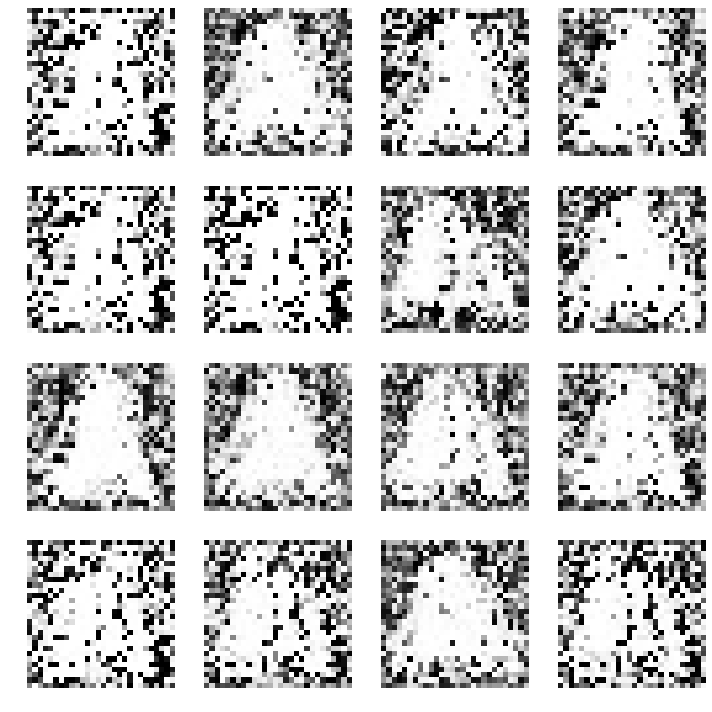

In [74]:
gan_tower.plot_images()